In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
import ogb
import ast
from scipy import stats

In [3]:
pd.set_option('display.max_rows', 100)

In [4]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader

In [5]:
cwd = os.getcwd()
print(cwd)
cwd_parent = os.path.abspath(os.path.join(cwd, os.pardir))
# cwd_parent = os.path.abspath(os.path.join(cwd, '../../'))
print(cwd_parent)

sys.path.append(cwd_parent)

/cluster/work/medinfmk/lm1-homes/skyriakos-lm1-home/data_to_migrate/chemprop_run/git/notebooks
/cluster/work/medinfmk/lm1-homes/skyriakos-lm1-home/data_to_migrate/chemprop_run/git


In [6]:
import deepadr
from deepadr.dataset import *
from deepadr.utilities import *
from deepadr.run_workflow import *
from deepadr.chemfeatures import *
from deepadr.hyphelperflat import *
from deepadr.model_gnn_ogb import GNN, DeepAdr_SiameseTrf, ExpressionNN
from ogb.graphproppred import Evaluator

In [7]:
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

In [8]:
from sklearn.preprocessing import StandardScaler

In [9]:
rawdata_dir = '../data/raw/'
processed_dir = '../data/processed/'
up_dir = '..'

In [10]:
report_available_cuda_devices()

number of GPUs available: 5
cuda:0, name:NVIDIA GeForce GTX 1080 Ti
total memory available: 10.91656494140625 GB
total memory allocated on device: 0.0 GB
max memory allocated on device: 0.0 GB
total memory cached on device: 0.0 GB
max memory cached  on device: 0.0 GB

cuda:1, name:NVIDIA GeForce GTX 1080 Ti
total memory available: 10.91656494140625 GB
total memory allocated on device: 0.0 GB
max memory allocated on device: 0.0 GB
total memory cached on device: 0.0 GB
max memory cached  on device: 0.0 GB

cuda:2, name:NVIDIA GeForce GTX 1080 Ti
total memory available: 10.91656494140625 GB
total memory allocated on device: 0.0 GB
max memory allocated on device: 0.0 GB
total memory cached on device: 0.0 GB
max memory cached  on device: 0.0 GB

cuda:3, name:NVIDIA GeForce GTX 1080 Ti
total memory available: 10.91656494140625 GB
total memory allocated on device: 0.0 GB
max memory allocated on device: 0.0 GB
total memory cached on device: 0.0 GB
max memory cached  on device: 0.0 GB

cuda:4, 

In [11]:
n_gpu = torch.cuda.device_count()
n_gpu

5

In [12]:
fdtype = torch.float32

In [13]:
print("torch:", torch.__version__)
print("CUDA:", torch.version.cuda)

torch: 1.11.0+cu115
CUDA: 11.5


### Preparing dataset 

In [14]:
# options: 
# 'total_thresh' + 4,3,2
# 'loewe_thresh', 'hsa_thresh', 'bliss_thresh', 'zip_thresh' + 1

score = 'zip_thresh'
score_val = 1

In [15]:
DSdataset_name = f'DrugComb_{score}_{score_val}'

data_fname = 'data_v4' # v2 for baseline models, v3 for additive samples, v4 for additive baseline

In [16]:
df_drugcomb = pd.read_csv(f'../data/preprocessing/drugcomb_{score}_{score_val}.csv')
df_drugcomb

,Drug1_ID,Drug2_ID,Cell_Line_ID,Cosmic_ID,Drug1,Drug2,Y
0,lonidamine,717906-29-1,A-673,684052,C1=CC=C2C(=C1)C(=NN2CC3=C(C=C(C=C3)Cl)Cl)C(=O)O,CN(C1=CC=CC=C1CNC2=NC(=NC=C2C(F)(F)F)NC3=CC4=C...,0
1,Ethyl bromopyruvate,717906-29-1,A-673,684052,CCOC(=O)C(=O)CBr,CN(C1=CC=CC=C1CNC2=NC(=NC=C2C(F)(F)F)NC3=CC4=C...,0
2,Tranilast (trans-),717906-29-1,A-673,684052,COC1=C(C=C(C=C1)C=CC(=O)NC2=CC=CC=C2C(=O)O)OC,CN(C1=CC=CC=C1CNC2=NC(=NC=C2C(F)(F)F)NC3=CC4=C...,0
3,Lenalidomide,717906-29-1,A-673,684052,C1CC(=O)NC(=O)C1N2CC3=C(C2=O)C=CC=C3N,CN(C1=CC=CC=C1CNC2=NC(=NC=C2C(F)(F)F)NC3=CC4=C...,0
4,Pomalidomide,717906-29-1,A-673,684052,C1CC(=O)NC(=O)C1N2C(=O)C3=C(C2=O)C(=CC=C3)N,CN(C1=CC=CC=C1CNC2=NC(=NC=C2C(F)(F)F)NC3=CC4=C...,0
...,...,...,...,...,...,...,...
417188,Saracatinib,Onalespib,VM-CUB-1,909780,CN1CCN(CC1)CCOC2=CC(=C3C(=C2)N=CN=C3NC4=C(C=CC...,CC(C)C1=C(C=C(C(=C1)C(=O)N2CC3=C(C2)C=C(C=C3)C...,0
417189,Saracatinib,AZD5582,VM-CUB-1,909780,CN1CCN(CC1)CCOC2=CC(=C3C(=C2)N=CN=C3NC4=C(C=CC...,CC(C(=O)NC(C1CCCCC1)C(=O)N2CCCC2C(=O)NC3C(CC4=...,0
417190,Saracatinib,Selumetinib,VM-CUB-1,909780,CN1CCN(CC1)CCOC2=CC(=C3C(=C2)N=CN=C3NC4=C(C=CC...,CN1C=NC2=C1C=C(C(=C2F)NC3=C(C=C(C=C3)Br)Cl)C(=...,0
417191,Saracatinib,Olaparib,VM-CUB-1,909780,CN1CCN(CC1)CCOC2=CC(=C3C(=C2)N=CN=C3NC4=C(C=CC...,C1CC1C(=O)N2CCN(CC2)C(=O)C3=C(C=CC(=C3)CC4=NNC...,0


In [17]:
df_rma_landm = pd.read_csv('../data/preprocessing/df_rma_landm.tsv', sep="\t")
df_rma_landm

,Unnamed: 0,GENE_SYMBOLS,GENE_title,DATA.906826,DATA.687983,DATA.910927,DATA.1240138,DATA.1240139,DATA.906792,DATA.910688,...,DATA.753584,DATA.907044,DATA.998184,DATA.908145,DATA.1659787,DATA.1298157,DATA.1480372,DATA.1298533,DATA.930299,DATA.905954.1
0,0,TSPAN6,tetraspanin 6 [Source:HGNC Symbol;Acc:11858],7.632023,7.548671,8.712338,7.797142,7.729268,7.074533,3.285198,...,7.105637,3.236503,3.038892,8.373223,6.932178,8.441628,8.422922,8.089255,3.112333,7.153127
1,3,SCYL3,SCY1-like 3 (S. cerevisiae) [Source:HGNC Symbo...,3.614794,4.066887,3.956230,4.063701,4.341500,4.270903,5.968168,...,3.696835,4.624013,4.348524,3.858121,3.947561,4.425849,3.550390,4.443337,4.266828,4.100493
2,19,BAD,BCL2-associated agonist of cell death [Source:...,7.458409,7.479327,7.419672,7.731137,6.998981,6.550210,6.354063,...,7.147962,6.478426,6.919537,6.801096,7.153122,7.234464,7.525257,6.066356,8.185968,4.967268
3,20,LAP3,leucine aminopeptidase 3 [Source:HGNC Symbol;A...,6.453926,6.742826,5.655691,5.259367,4.611395,6.930777,8.560707,...,5.383810,8.591164,6.208059,6.715130,6.530806,5.759933,7.810126,7.182077,5.663629,6.539451
4,28,SNX11,sorting nexin 11 [Source:HGNC Symbol;Acc:14975],4.767457,5.246301,4.645800,4.558836,5.456692,5.099542,7.574348,...,4.755084,6.761799,5.034195,4.958603,4.629068,4.982202,5.037259,4.611973,4.800284,4.967207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
903,17083,PLEKHM1,"pleckstrin homology domain containing, family ...",6.167946,5.271099,5.784561,7.587263,6.479184,5.700915,6.617353,...,6.714959,6.368537,8.252268,6.436644,6.436742,5.551436,5.634834,7.083564,5.776658,6.306988
904,17400,MIF,macrophage migration inhibitory factor (glycos...,11.893872,11.841300,12.272137,12.000410,11.867211,12.621575,11.825283,...,12.286071,12.572595,12.254136,12.588238,12.366026,12.153612,12.265099,11.919307,12.762295,12.985613
905,17444,PRAF2,"PRA1 domain family, member 2 [Source:HGNC Symb...",5.060852,6.515567,4.815762,4.544863,6.071288,4.777850,3.455981,...,5.314914,2.943601,4.723601,5.769965,5.070665,3.443244,3.293080,2.978125,5.125786,4.404205
906,17575,LYN,v-yes-1 Yamaguchi sarcoma viral related oncoge...,5.892532,4.580184,6.482469,7.094195,7.932918,7.333405,10.455397,...,4.914232,9.453552,3.218797,4.073831,6.355383,8.348965,7.579339,4.456322,5.857488,3.013612


In [18]:
targetdata_dir = create_directory(os.path.join(processed_dir, DSdataset_name, data_fname))
targetdata_dir_raw = create_directory(os.path.join(targetdata_dir, "raw"))
targetdata_dir_processed = create_directory(os.path.join(targetdata_dir, "processed"))
# ReaderWriter.dump_data(dpartitions, os.path.join(targetdata_dir, 'data_partitions.pkl'))

path_current_dir /cluster/work/medinfmk/lm1-homes/skyriakos-lm1-home/data_to_migrate/chemprop_run/git/deepadr
path_current_dir /cluster/work/medinfmk/lm1-homes/skyriakos-lm1-home/data_to_migrate/chemprop_run/git/deepadr
path_current_dir /cluster/work/medinfmk/lm1-homes/skyriakos-lm1-home/data_to_migrate/chemprop_run/git/deepadr


In [19]:
targetdata_dir

'/cluster/work/medinfmk/lm1-homes/skyriakos-lm1-home/data_to_migrate/chemprop_run/git/data/processed/DrugComb_zip_thresh_1/data_v4'

In [20]:
data = df_drugcomb
data

,Drug1_ID,Drug2_ID,Cell_Line_ID,Cosmic_ID,Drug1,Drug2,Y
0,lonidamine,717906-29-1,A-673,684052,C1=CC=C2C(=C1)C(=NN2CC3=C(C=C(C=C3)Cl)Cl)C(=O)O,CN(C1=CC=CC=C1CNC2=NC(=NC=C2C(F)(F)F)NC3=CC4=C...,0
1,Ethyl bromopyruvate,717906-29-1,A-673,684052,CCOC(=O)C(=O)CBr,CN(C1=CC=CC=C1CNC2=NC(=NC=C2C(F)(F)F)NC3=CC4=C...,0
2,Tranilast (trans-),717906-29-1,A-673,684052,COC1=C(C=C(C=C1)C=CC(=O)NC2=CC=CC=C2C(=O)O)OC,CN(C1=CC=CC=C1CNC2=NC(=NC=C2C(F)(F)F)NC3=CC4=C...,0
3,Lenalidomide,717906-29-1,A-673,684052,C1CC(=O)NC(=O)C1N2CC3=C(C2=O)C=CC=C3N,CN(C1=CC=CC=C1CNC2=NC(=NC=C2C(F)(F)F)NC3=CC4=C...,0
4,Pomalidomide,717906-29-1,A-673,684052,C1CC(=O)NC(=O)C1N2C(=O)C3=C(C2=O)C(=CC=C3)N,CN(C1=CC=CC=C1CNC2=NC(=NC=C2C(F)(F)F)NC3=CC4=C...,0
...,...,...,...,...,...,...,...
417188,Saracatinib,Onalespib,VM-CUB-1,909780,CN1CCN(CC1)CCOC2=CC(=C3C(=C2)N=CN=C3NC4=C(C=CC...,CC(C)C1=C(C=C(C(=C1)C(=O)N2CC3=C(C2)C=C(C=C3)C...,0
417189,Saracatinib,AZD5582,VM-CUB-1,909780,CN1CCN(CC1)CCOC2=CC(=C3C(=C2)N=CN=C3NC4=C(C=CC...,CC(C(=O)NC(C1CCCCC1)C(=O)N2CCCC2C(=O)NC3C(CC4=...,0
417190,Saracatinib,Selumetinib,VM-CUB-1,909780,CN1CCN(CC1)CCOC2=CC(=C3C(=C2)N=CN=C3NC4=C(C=CC...,CN1C=NC2=C1C=C(C(=C2F)NC3=C(C=C(C=C3)Br)Cl)C(=...,0
417191,Saracatinib,Olaparib,VM-CUB-1,909780,CN1CCN(CC1)CCOC2=CC(=C3C(=C2)N=CN=C3NC4=C(C=CC...,C1CC1C(=O)N2CCN(CC2)C(=O)C3=C(C=CC(=C3)CC4=NNC...,0


In [21]:
data = data.drop(index=data[(data.Drug1.str.contains("Antibody")) | (data.Drug2.str.contains("Antibody"))].index)
data.index = range(len(data))
len(data)

416957

In [22]:
uniq_data = ddi_dataframe_to_unique_drugs(data)
uniq_data

,Drug_ID,Drug
0,lonidamine,C1=CC=C2C(=C1)C(=NN2CC3=C(C=C(C=C3)Cl)Cl)C(=O)O
1,Ethyl bromopyruvate,CCOC(=O)C(=O)CBr
2,Tranilast (trans-),COC1=C(C=C(C=C1)C=CC(=O)NC2=CC=CC=C2C(=O)O)OC
3,Lenalidomide,C1CC(=O)NC(=O)C1N2CC3=C(C2=O)C=CC=C3N
4,Pomalidomide,C1CC(=O)NC(=O)C1N2C(=O)C3=C(C2=O)C(=CC=C3)N
...,...,...
3114,CHEMBL2325704,CS(=O)(=O)C1(CC1)C2=CC(=NC(=N2)C3=C4C=CNC4=CC=...
3115,SCHEMBL1559365,CC1=NN(C=C1NC2=NC=C(C(=C2)NC3=C(C=C(C=C3)F)C(=...
3116,SCHEMBL1557791,CC1=NN(C=C1NC2=NC=C(C(=C2)NC3=CC=CC=C3C(=O)NC)...
3117,LSM-4270,CC1=C2C(C(=O)C3(C(CC4C(C3C(C(C2(C)C)(CC1OC(=O)...


In [23]:
uniq_data.Drug = [d.split("; ")[1] if ("; " in d) else d for d in uniq_data.Drug]
uniq_data.Drug = [d.split(";")[1] if (";" in d) else d for d in uniq_data.Drug]

In [24]:
uniq_data['Mol'] = [smiles_to_mol(smiles) for smiles in uniq_data.Drug]

In [25]:
uniq_mol = uniq_data[~uniq_data.Mol.isnull()]
# uniq_mol['Data'] = [mol_to_graph_data_obj_simple(mol) for mol in uniq_mol.Mol]
uniq_mol['DataOGB'] = [smiles_to_graph_data_obj_ogb(smiles) for smiles in uniq_mol.Drug]
uniq_mol = uniq_mol.set_index("Drug_ID")
uniq_mol

,Drug,Mol,DataOGB
Drug_ID,,,
lonidamine,C1=CC=C2C(=C1)C(=NN2CC3=C(C=C(C=C3)Cl)Cl)C(=O)O,<rdkit.Chem.rdchem.Mol object at 0x149a4930e160>,"[(edge_index, [tensor([ 0, 1, 1, 2, 2, 3,..."
Ethyl bromopyruvate,CCOC(=O)C(=O)CBr,<rdkit.Chem.rdchem.Mol object at 0x149a4930ff40>,"[(edge_index, [tensor([0, 1, 1, 2, 2, 3, 3, 4,..."
Tranilast (trans-),COC1=C(C=C(C=C1)C=CC(=O)NC2=CC=CC=C2C(=O)O)OC,<rdkit.Chem.rdchem.Mol object at 0x149a4930fa00>,"[(edge_index, [tensor([ 0, 1, 1, 2, 2, 3,..."
Lenalidomide,C1CC(=O)NC(=O)C1N2CC3=C(C2=O)C=CC=C3N,<rdkit.Chem.rdchem.Mol object at 0x149a4930ffa0>,"[(edge_index, [tensor([ 0, 1, 1, 2, 2, 3,..."
Pomalidomide,C1CC(=O)NC(=O)C1N2C(=O)C3=C(C2=O)C(=CC=C3)N,<rdkit.Chem.rdchem.Mol object at 0x149a4930fee0>,"[(edge_index, [tensor([ 0, 1, 1, 2, 2, 3,..."
...,...,...,...
CHEMBL2325704,CS(=O)(=O)C1(CC1)C2=CC(=NC(=N2)C3=C4C=CNC4=CC=...,<rdkit.Chem.rdchem.Mol object at 0x149a49304700>,"[(edge_index, [tensor([ 0, 1, 1, 2, 1, 3,..."
SCHEMBL1559365,CC1=NN(C=C1NC2=NC=C(C(=C2)NC3=C(C=C(C=C3)F)C(=...,<rdkit.Chem.rdchem.Mol object at 0x149a49304760>,"[(edge_index, [tensor([ 0, 1, 1, 2, 2, 3,..."
SCHEMBL1557791,CC1=NN(C=C1NC2=NC=C(C(=C2)NC3=CC=CC=C3C(=O)NC)...,<rdkit.Chem.rdchem.Mol object at 0x149a493047c0>,"[(edge_index, [tensor([ 0, 1, 1, 2, 2, 3,..."


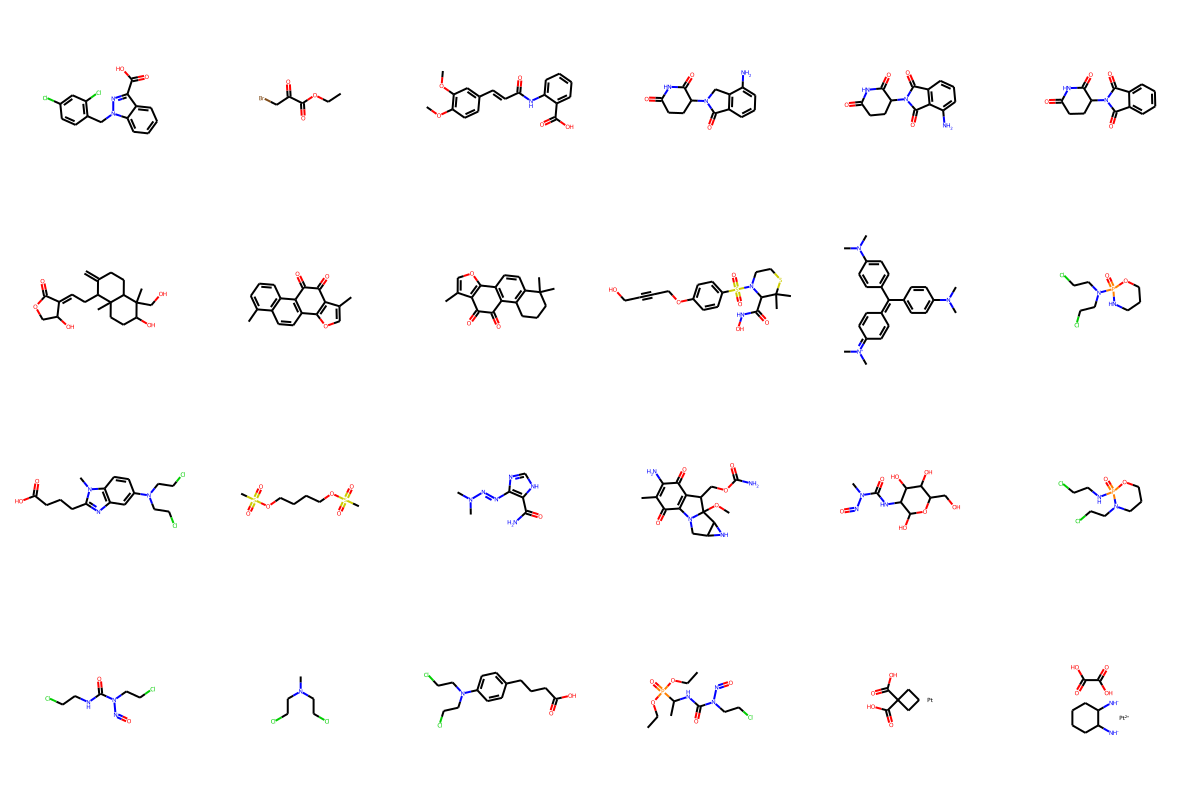

In [26]:
Draw.MolsToGridImage(uniq_mol.Mol.head(24), molsPerRow=6)

In [27]:
uniq_mol.iloc[0].DataOGB

Data(edge_index=[2, 46], edge_attr=[46, 3], x=[21, 9])

In [28]:
if (data_fname == 'data_v2' or data_fname == 'data_v4'): #baseline model
    print("generating xFlat for", data_fname)
    uniq_mol['xFlat'] = [torch.mean(torch.clone(data.x).type(torch.float32), dim=0) for data in uniq_mol['DataOGB']]

generating xFlat for data_v4


In [29]:
# uniq_mol.iloc[0].DataOGB.x

In [30]:
y = data.Y.copy()
y

0         0
1         0
2         0
3         0
4         0
         ..
416952    0
416953    0
416954    0
416955    0
416956    0
Name: Y, Length: 416957, dtype: int64

In [31]:
y.value_counts()

0    367333
1     49624
Name: Y, dtype: int64

In [32]:
ReaderWriter.dump_data(y.values, os.path.join(targetdata_dir_raw, 'y.pkl'))

In [33]:
# y_weights = compute_class_weights(torch.tensor(y))
# y_weights

In [34]:
# ReaderWriter.dump_data(y_weights, os.path.join(targetdata_dir_raw, 'y_weights.pkl'))

In [35]:
df_rma_landm.shape

(908, 1021)

In [36]:
expression = np.array([df_rma_landm['DATA.'+ str(c)].values for c in data["Cosmic_ID"]])
expression.shape

(416957, 908)

In [37]:
df_rma_landm

,Unnamed: 0,GENE_SYMBOLS,GENE_title,DATA.906826,DATA.687983,DATA.910927,DATA.1240138,DATA.1240139,DATA.906792,DATA.910688,...,DATA.753584,DATA.907044,DATA.998184,DATA.908145,DATA.1659787,DATA.1298157,DATA.1480372,DATA.1298533,DATA.930299,DATA.905954.1
0,0,TSPAN6,tetraspanin 6 [Source:HGNC Symbol;Acc:11858],7.632023,7.548671,8.712338,7.797142,7.729268,7.074533,3.285198,...,7.105637,3.236503,3.038892,8.373223,6.932178,8.441628,8.422922,8.089255,3.112333,7.153127
1,3,SCYL3,SCY1-like 3 (S. cerevisiae) [Source:HGNC Symbo...,3.614794,4.066887,3.956230,4.063701,4.341500,4.270903,5.968168,...,3.696835,4.624013,4.348524,3.858121,3.947561,4.425849,3.550390,4.443337,4.266828,4.100493
2,19,BAD,BCL2-associated agonist of cell death [Source:...,7.458409,7.479327,7.419672,7.731137,6.998981,6.550210,6.354063,...,7.147962,6.478426,6.919537,6.801096,7.153122,7.234464,7.525257,6.066356,8.185968,4.967268
3,20,LAP3,leucine aminopeptidase 3 [Source:HGNC Symbol;A...,6.453926,6.742826,5.655691,5.259367,4.611395,6.930777,8.560707,...,5.383810,8.591164,6.208059,6.715130,6.530806,5.759933,7.810126,7.182077,5.663629,6.539451
4,28,SNX11,sorting nexin 11 [Source:HGNC Symbol;Acc:14975],4.767457,5.246301,4.645800,4.558836,5.456692,5.099542,7.574348,...,4.755084,6.761799,5.034195,4.958603,4.629068,4.982202,5.037259,4.611973,4.800284,4.967207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
903,17083,PLEKHM1,"pleckstrin homology domain containing, family ...",6.167946,5.271099,5.784561,7.587263,6.479184,5.700915,6.617353,...,6.714959,6.368537,8.252268,6.436644,6.436742,5.551436,5.634834,7.083564,5.776658,6.306988
904,17400,MIF,macrophage migration inhibitory factor (glycos...,11.893872,11.841300,12.272137,12.000410,11.867211,12.621575,11.825283,...,12.286071,12.572595,12.254136,12.588238,12.366026,12.153612,12.265099,11.919307,12.762295,12.985613
905,17444,PRAF2,"PRA1 domain family, member 2 [Source:HGNC Symb...",5.060852,6.515567,4.815762,4.544863,6.071288,4.777850,3.455981,...,5.314914,2.943601,4.723601,5.769965,5.070665,3.443244,3.293080,2.978125,5.125786,4.404205
906,17575,LYN,v-yes-1 Yamaguchi sarcoma viral related oncoge...,5.892532,4.580184,6.482469,7.094195,7.932918,7.333405,10.455397,...,4.914232,9.453552,3.218797,4.073831,6.355383,8.348965,7.579339,4.456322,5.857488,3.013612


In [38]:
# scaler = StandardScaler()
# pipeline = compose(scaler.fit_transform, np.tanh, scaler.fit_transform)

In [39]:
# expression_norm = pipeline(expression)
# expression_norm

In [40]:
# ReaderWriter.dump_data(expression_norm, os.path.join(targetdata_dir_raw, 'expression.pkl'))
ReaderWriter.dump_data(expression, os.path.join(targetdata_dir_raw, 'expression.pkl'))

In [41]:
pairs = {i:(row.Drug1_ID, row.Drug2_ID) for i, row in data.iterrows()}
len(pairs)

416957

In [42]:
pairs

{0: ('lonidamine', '717906-29-1'),
 1: ('Ethyl bromopyruvate', '717906-29-1'),
 2: ('Tranilast (trans-)', '717906-29-1'),
 3: ('Lenalidomide', '717906-29-1'),
 4: ('Pomalidomide', '717906-29-1'),
 5: ('thalidomide', '717906-29-1'),
 6: ('CHEMBL3348980', '717906-29-1'),
 7: ('Tanshinone I', '717906-29-1'),
 8: ('Tanshinone IIA', '717906-29-1'),
 9: ('NCGC00263092-01', '717906-29-1'),
 10: ('Gentian violet cation', '717906-29-1'),
 11: ('cyclophosphamide', '717906-29-1'),
 12: ('Bendamustine', '717906-29-1'),
 13: ('busulfan', '717906-29-1'),
 14: ('dacarbazine', '717906-29-1'),
 15: ('mitomycin C', '717906-29-1'),
 16: ('NCGC00025235-01', '717906-29-1'),
 17: ('ifosfamide', '717906-29-1'),
 18: ('carmustine', '717906-29-1'),
 19: ('mechlorethamine', '717906-29-1'),
 20: ('chlorambucil', '717906-29-1'),
 21: ('Fotemustine', '717906-29-1'),
 22: ('KBio2_007145', '717906-29-1'),
 23: ('NCGC00167798-01', '717906-29-1'),
 24: ('cis-Diaminedichloroplatinum', '717906-29-1'),
 25: ('Nedaplatin'

In [43]:
ReaderWriter.dump_data(pairs, os.path.join(targetdata_dir_raw, 'pairs.pkl'))

In [44]:
ReaderWriter.dump_data(data, os.path.join(targetdata_dir_raw, 'data_pairs.pkl'))

In [45]:
%%time

if (data_fname == 'data_v1' or data_fname == 'data_v3'): #gnn model
    X = ReaderWriter.read_or_dump_data(file_name=norm_join_paths(targetdata_dir_raw, 'X.pkl'),
                              data_gen_fun=get_X_all_pairdata_synergy,
                              data_gen_params=(uniq_mol, pairs, "DataOGB"))
    
if (data_fname == 'data_v2' or data_fname == 'data_v4'): #baseline model
    X = ReaderWriter.read_or_dump_data(file_name=norm_join_paths(targetdata_dir_raw, 'X_flat.pkl'),
                              data_gen_fun=get_X_all_pairdata_synergy_flat,
                              data_gen_params=(uniq_mol, pairs, "xFlat"))

CPU times: user 54.5 s, sys: 77.7 ms, total: 54.6 s
Wall time: 54.6 s


In [46]:
# %%time

# # In order to generate a new Dataset, first remove the generated files above

# dataset = MoleculeDataset(root=targetdata_dir, dataset='tdcSynergy')

In [47]:
# print()
# print(f'Dataset: {dataset}:')
# print('====================')
# print(f'Number of graphs: {len(dataset)}')
# print(f'Number of features: {dataset.num_features}')
# print(f'Number of classes: {dataset.num_classes}')

In [48]:
# data0 = dataset[0]  # Get the first graph object.
# data0

In [49]:
# dataset.data.expression

In [50]:
# len(dataset)